In [ ]:
!pip install mediapipe opencv-python tensorflow==2.15.0 scikit-learn matplotlib seaborn kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 562.5 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import zipfile
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

print("Pustaka berhasil diinstal dan diimpor.")
print(f"Versi TensorFlow: {tf.__version__}")
print(f"Versi NumPy: {np.__version__}")
print(f"Versi MediaPipe: {mp.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pustaka berhasil diinstal dan diimpor.
Versi TensorFlow: 2.15.0
Versi NumPy: 1.26.4
Versi MediaPipe: 0.10.21


In [ ]:
DRIVE_BASE_PATH = '/content/drive/MyDrive/Capstone'
DATASET_ROOT_PATH = os.path.join(DRIVE_BASE_PATH, 'dataset_isyarat')
RAW_DATA_PATH = os.path.join(DATASET_ROOT_PATH, 'raw_data')
PROCESSED_DATA_PATH = os.path.join(DRIVE_BASE_PATH, 'processed_hybrid_data')
MODELS_PATH = os.path.join(DRIVE_BASE_PATH, 'models_hybrid')

os.makedirs(DATASET_ROOT_PATH, exist_ok=True)
os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

print(f"Path dasar proyek: {DRIVE_BASE_PATH}")
print(f"Path dataset (root): {DATASET_ROOT_PATH}")
print(f"Path data mentah (kelas): {RAW_DATA_PATH}")
print(f"Path data diproses: {PROCESSED_DATA_PATH}")
print(f"Path model: {MODELS_PATH}")

Path dasar proyek: /content/drive/MyDrive/Capstone
Path dataset (root): /content/drive/MyDrive/Capstone/dataset_isyarat
Path data mentah (kelas): /content/drive/MyDrive/Capstone/dataset_isyarat/raw_data
Path data diproses: /content/drive/MyDrive/Capstone/processed_hybrid_data
Path model: /content/drive/MyDrive/Capstone/models_hybrid


In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
NUM_LANDMARK_FEATURES = 42
BATCH_SIZE = 32

print("Silakan unggah file 'kaggle.json' Anda.")
try:
    uploaded = files.upload()
    if 'kaggle.json' not in uploaded:
        raise FileNotFoundError("kaggle.json tidak diunggah.")
    print("kaggle.json berhasil diunggah.")

    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    shutil.copy('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
    print("Kredensial Kaggle berhasil disiapkan.")
    zip_download_path = DATASET_ROOT_PATH
    zip_file_name = 'alfabet-bisindo.zip'
    full_zip_path = os.path.join(zip_download_path, zip_file_name)


    print(f"Mengunduh dataset 'achmadnoer/alfabet-bisindo' ke: {zip_download_path}")

    !kaggle datasets download -d achmadnoer/alfabet-bisindo -p {zip_download_path} --force

    print(f"Dataset selesai diunduh. File zip seharusnya ada di: {full_zip_path}")
    if os.path.exists(full_zip_path):
        print(f"Mengekstrak '{full_zip_path}' ke '{RAW_DATA_PATH}'...")
        with zipfile.ZipFile(full_zip_path, 'r') as zip_ref:
            zip_ref.extractall(RAW_DATA_PATH)
        print(f"Dataset berhasil diekstrak ke {RAW_DATA_PATH}.")

        extracted_items = os.listdir(RAW_DATA_PATH)
        print(f"Isi dari {RAW_DATA_PATH} setelah ekstraksi: {extracted_items[:5]} ...")

        if len(extracted_items) == 1 and os.path.isdir(os.path.join(RAW_DATA_PATH, extracted_items[0])):
            potential_main_folder_name = extracted_items[0]
            if os.path.isdir(os.path.join(RAW_DATA_PATH, potential_main_folder_name, 'A')):
                print(f"Folder kelas tampaknya berada di dalam subfolder '{potential_main_folder_name}'.")

                actual_class_folder_path = os.path.join(RAW_DATA_PATH, potential_main_folder_name)
                print(f"Path yang seharusnya digunakan untuk memproses dataset (berisi folder A,B,C): {actual_class_folder_path}")

    else:
        print(f"Error: File zip '{full_zip_path}' tidak ditemukan setelah diunduh. Periksa output unduhan Kaggle.")

    if not os.listdir(RAW_DATA_PATH):
        print(f"PERHATIAN: Folder {RAW_DATA_PATH} kosong atau tidak berisi folder kelas yang diharapkan.")
        print("Pastikan dataset diekstrak dengan benar dan RAW_DATA_PATH (atau subfoldernya) berisi folder A, B, C, dll.")
    else:
        print("Dataset siap untuk langkah pemrosesan selanjutnya.")

except FileNotFoundError as e:
    print(f"Error FileNotFoundError: {e}. Pastikan Anda mengunggah kaggle.json.")
except zipfile.BadZipFile:
    print(f"Error: File '{full_zip_path}' bukan file zip yang valid atau rusak.")
except Exception as e:
    print(f"Terjadi kesalahan lain: {e}")

Silakan unggah file 'kaggle.json' Anda.


Saving kaggle.json to kaggle.json
kaggle.json berhasil diunggah.
Kredensial Kaggle berhasil disiapkan.
Mengunduh dataset 'achmadnoer/alfabet-bisindo' ke: /content/drive/MyDrive/Capstone/dataset_isyarat
Dataset URL: https://www.kaggle.com/datasets/achmadnoer/alfabet-bisindo
License(s): CC0-1.0
 95% 109M/115M [00:01<00:00, 104MB/s]  
100% 115M/115M [00:01<00:00, 61.4MB/s]
Dataset selesai diunduh. File zip seharusnya ada di: /content/drive/MyDrive/Capstone/dataset_isyarat/alfabet-bisindo.zip
Mengekstrak '/content/drive/MyDrive/Capstone/dataset_isyarat/alfabet-bisindo.zip' ke '/content/drive/MyDrive/Capstone/dataset_isyarat/raw_data'...
Dataset berhasil diekstrak ke /content/drive/MyDrive/Capstone/dataset_isyarat/raw_data.
Isi dari /content/drive/MyDrive/Capstone/dataset_isyarat/raw_data setelah ekstraksi: ['Citra BISINDO'] ...
Folder kelas tampaknya berada di dalam subfolder 'Citra BISINDO'.
Path yang seharusnya digunakan untuk memproses dataset (berisi folder A,B,C): /content/drive/MyDri

In [ ]:
def extract_landmarks_from_image(image_bgr, hands_solution_instance):
    """
    Mengekstrak landmark tangan dari satu gambar BGR menggunakan instance hands yang diberikan.
    Mengembalikan array NumPy yang dinormalisasi dari landmark (x, y) atau None.
    """
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb.flags.writeable = False
    results = hands_solution_instance.process(image_rgb)
    image_rgb.flags.writeable = True

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        landmarks_list = []
        for landmark in hand_landmarks.landmark:
            landmarks_list.append(landmark.x)
            landmarks_list.append(landmark.y)


        base_x, base_y = landmarks_list[0], landmarks_list[1]
        normalized_landmarks = []
        for i in range(0, len(landmarks_list), 2):
            normalized_landmarks.append(landmarks_list[i] - base_x)
            normalized_landmarks.append(landmarks_list[i+1] - base_y)



        max_val = np.max(np.abs(normalized_landmarks))
        if max_val == 0: max_val = 1e-6
        scaled_landmarks = np.array(normalized_landmarks) / max_val

        if len(scaled_landmarks.flatten()) == NUM_LANDMARK_FEATURES:
            return scaled_landmarks.flatten()
        else:
            return None
    return None

    print("Fungsi extract_landmarks_from_image siap.")

In [ ]:
def process_hybrid_dataset(dataset_dir, output_dir, img_height, img_width):
    """
    Memproses semua gambar: me-resize gambar dan mengekstrak landmark.
    Menyimpan gambar yang diproses, landmark, label, dan nama kelas.
    """
    print(f"Memulai pemrosesan dataset hibrida dari: {dataset_dir}")
    all_resized_images = []
    all_landmarks = []
    all_labels = []

    if not os.path.isdir(dataset_dir):
        print(f"Error: Direktori dataset awal '{dataset_dir}' tidak ditemukan.")
        return [], [], [], []

    current_items = os.listdir(dataset_dir)
    potential_class_parent_folders = [d for d in current_items if os.path.isdir(os.path.join(dataset_dir, d))]

    if len(potential_class_parent_folders) == 1:
        single_subfolder_name = potential_class_parent_folders[0]
        path_to_single_subfolder = os.path.join(dataset_dir, single_subfolder_name)

        items_in_single_subfolder = os.listdir(path_to_single_subfolder)
        if any(os.path.isdir(os.path.join(path_to_single_subfolder, item)) for item in items_in_single_subfolder):
            print(f"Folder kelas tampaknya berada di dalam subfolder: '{path_to_single_subfolder}'. Menggunakan path ini untuk pemrosesan.")
            dataset_dir = path_to_single_subfolder

    if os.path.exists(output_dir):
        print(f"Menghapus konten lama di {output_dir}...")
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)


    class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
    if not class_names:
        print(f"Tidak ada folder kelas ditemukan di '{dataset_dir}' setelah penyesuaian (jika ada).")
        return [], [], [], []
    print(f"Kelas yang ditemukan untuk diproses: {class_names}")

    mp_hands_module = mp.solutions.hands
    hands_processor = mp_hands_module.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    skipped_due_to_no_landmarks = 0
    skipped_due_to_read_error = 0

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_dir, class_name)
        num_images_processed_in_class = 0
        print(f"Memproses kelas: {class_name} (indeks: {class_index})")

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            print(f"  Tidak ada file gambar ditemukan di {class_path}")
            continue

        for image_name in image_files:
            image_path = os.path.join(class_path, image_name)
            image_bgr = cv2.imread(image_path)

            if image_bgr is None:
                skipped_due_to_read_error += 1
                continue

            resized_image = cv2.resize(image_bgr, (img_width, img_height))
            landmarks = extract_landmarks_from_image(image_bgr, hands_processor)

            if landmarks is not None:
                all_resized_images.append(resized_image)
                all_landmarks.append(landmarks)
                all_labels.append(class_index)
                num_images_processed_in_class += 1
            else:
                skipped_due_to_no_landmarks += 1

        print(f"  Selesai memproses kelas {class_name}. Gambar berhasil diproses: {num_images_processed_in_class}")

    hands_processor.close()
    print(f"\nTotal gambar dilewati karena error baca: {skipped_due_to_read_error}")
    print(f"Total gambar dilewati karena tidak ada landmark terdeteksi: {skipped_due_to_no_landmarks}")

    if not all_resized_images:
        print("Tidak ada data yang berhasil diproses dari dataset.")
        return [], [], [], class_names

    all_resized_images_np = np.array(all_resized_images)
    all_landmarks_np = np.array(all_landmarks)
    all_labels_np = np.array(all_labels)

    np.save(os.path.join(output_dir, 'processed_images.npy'), all_resized_images_np)
    np.save(os.path.join(output_dir, 'processed_landmarks.npy'), all_landmarks_np)
    np.save(os.path.join(output_dir, 'processed_labels.npy'), all_labels_np)
    with open(os.path.join(output_dir, 'class_names.txt'), 'w') as f:
        for name in class_names:
            f.write(f"{name}\n")

    print(f"Data hibrida (gambar dan landmark) berhasil disimpan di {output_dir}")
    print(f"Bentuk array gambar: {all_resized_images_np.shape}")
    print(f"Bentuk array landmark: {all_landmarks_np.shape}")
    print(f"Bentuk array label: {all_labels_np.shape}")

    return all_resized_images_np, all_landmarks_np, all_labels_np, class_names


if os.path.exists(RAW_DATA_PATH):
    images_data, landmarks_data, labels_data, class_names_loaded = process_hybrid_dataset(
        RAW_DATA_PATH, PROCESSED_DATA_PATH, IMAGE_HEIGHT, IMAGE_WIDTH
    )
else:
    print(f"Folder dataset dasar di {RAW_DATA_PATH} tidak ditemukan. Pemrosesan dilewati.")
    images_data, landmarks_data, labels_data, class_names_loaded = [], [], [], []

Memulai pemrosesan dataset hibrida dari: /content/drive/MyDrive/Capstone/dataset_isyarat/raw_data
Folder kelas tampaknya berada di dalam subfolder: '/content/drive/MyDrive/Capstone/dataset_isyarat/raw_data/Citra BISINDO'. Menggunakan path ini untuk pemrosesan.
Menghapus konten lama di /content/drive/MyDrive/Capstone/processed_hybrid_data...
Kelas yang ditemukan untuk diproses: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Memproses kelas: A (indeks: 0)
  Selesai memproses kelas A. Gambar berhasil diproses: 12
Memproses kelas: B (indeks: 1)
  Selesai memproses kelas B. Gambar berhasil diproses: 8
Memproses kelas: C (indeks: 2)
  Selesai memproses kelas C. Gambar berhasil diproses: 12
Memproses kelas: D (indeks: 3)
  Selesai memproses kelas D. Gambar berhasil diproses: 11
Memproses kelas: E (indeks: 4)
  Selesai memproses kelas E. Gambar berhasil diproses: 12
Memproses kelas: F (indeks: 5)
  Selesai memp

In [ ]:
LOAD_PROCESSED_DATA = True
if LOAD_PROCESSED_DATA or 'images_data' not in locals() or not isinstance(images_data, np.ndarray) or images_data.size == 0:
    print("Memuat data gambar, landmark, dan label yang sudah diproses...")
    try:
        images_data = np.load(os.path.join(PROCESSED_DATA_PATH, 'processed_images.npy'))
        landmarks_data = np.load(os.path.join(PROCESSED_DATA_PATH, 'processed_landmarks.npy'))
        labels_data = np.load(os.path.join(PROCESSED_DATA_PATH, 'processed_labels.npy'))
        with open(os.path.join(PROCESSED_DATA_PATH, 'class_names.txt'), 'r') as f:
            class_names_loaded = [line.strip() for line in f.readlines()]
        print("Data berhasil dimuat.")
        print(f"  Bentuk gambar: {images_data.shape}")
        print(f"  Bentuk landmark: {landmarks_data.shape}")
        print(f"  Bentuk label: {labels_data.shape}")
        print(f"  Nama kelas: {class_names_loaded[:5]}... (Total: {len(class_names_loaded)})")
    except FileNotFoundError:
        print(f"Error: File data yang diproses tidak ditemukan di {PROCESSED_DATA_PATH}.")
        print("Pastikan Anda telah menjalankan sel pemrosesan dataset terlebih dahulu.")
        images_data, landmarks_data, labels_data, class_names_loaded = [], [], [], []
    except Exception as e:
        print(f"Terjadi error saat memuat data: {e}")
        images_data, landmarks_data, labels_data, class_names_loaded = [], [], [], []

if isinstance(images_data, np.ndarray) and images_data.size > 0 and \
   isinstance(landmarks_data, np.ndarray) and landmarks_data.size > 0 and \
   isinstance(labels_data, np.ndarray) and labels_data.size > 0 and \
   class_names_loaded:

    images_data_normalized = images_data.astype('float32') / 255.0
    num_classes = len(class_names_loaded)
    if num_classes == 0:
        print("Error: Tidak ada kelas yang dimuat. Tidak dapat melanjutkan.")
        X_images_train, X_landmarks_train, y_train = None, None, None
        X_images_val, X_landmarks_val, y_val = None, None, None
        X_images_test, X_landmarks_test, y_test = None, None, None
    else:
        labels_categorical = to_categorical(labels_data, num_classes=num_classes)

        X_images_train_orig, X_images_temp, \
        X_landmarks_train_orig, X_landmarks_temp, \
        y_train_orig, y_temp = train_test_split(
            images_data_normalized,
            landmarks_data,
            labels_categorical,
            test_size=0.3,
            random_state=42,
            stratify=labels_categorical
        )

        y_temp_1d_labels = np.argmax(y_temp, axis=1) if y_temp.ndim > 1 else y_temp


        if y_temp_1d_labels.size > 0:
            class_counts_temp = np.bincount(y_temp_1d_labels)
            min_class_count_temp = np.min(class_counts_temp[class_counts_temp > 0]) if len(class_counts_temp[class_counts_temp > 0]) > 0 else 0
        else:
            min_class_count_temp = 0

        stratify_val_test = None
        if min_class_count_temp >= 2:
            stratify_val_test = y_temp
            print("Melakukan stratifikasi untuk pembagian validation/test set.")
        elif y_temp.size > 0 :
             print(f"Peringatan: Kelas dengan sampel paling sedikit di y_temp hanya memiliki {min_class_count_temp} anggota.")
             print("Pembagian validation/test set akan dilakukan tanpa stratifikasi untuk menghindari error.")


        X_images_val, X_images_test, \
        X_landmarks_val, X_landmarks_test, \
        y_val, y_test = train_test_split(
            X_images_temp,
            X_landmarks_temp,
            y_temp,
            test_size=0.5,
            random_state=42,
            stratify=stratify_val_test
        )

        print(f"\nData berhasil dipersiapkan (sebelum augmentasi):")
        print(f"  Bentuk X_images_train_orig: {X_images_train_orig.shape}")
        print(f"  Bentuk X_landmarks_train_orig: {X_landmarks_train_orig.shape}")
        print(f"  Bentuk y_train_orig: {y_train_orig.shape}")
        print(f"  Bentuk X_images_val: {X_images_val.shape}")
        print(f"  Bentuk X_landmarks_val: {X_landmarks_val.shape}")
        print(f"  Bentuk y_val: {y_val.shape}")
        print(f"  Bentuk X_images_test: {X_images_test.shape}")
        print(f"  Bentuk X_landmarks_test: {X_landmarks_test.shape}")
        print(f"  Bentuk y_test: {y_test.shape}")
        print(f"  Jumlah kelas: {num_classes}")

        train_image_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        def hybrid_data_generator(images, landmarks, labels, batch_size, image_data_generator):
            num_samples = images.shape[0]
            if num_samples == 0:
                print("Peringatan: Tidak ada sampel data untuk generator.")
                yield ({'image_input': np.array([]), 'landmark_input': np.array([])}, np.array([]))
                return

            while True:
                indices = np.random.choice(num_samples, batch_size)
                batch_images_orig = images[indices]
                batch_landmarks = landmarks[indices]
                batch_labels = labels[indices]

                batch_images_augmented = np.empty_like(batch_images_orig)
                for i in range(batch_images_orig.shape[0]):
                    batch_images_augmented[i] = image_data_generator.random_transform(batch_images_orig[i])

                yield ({'image_input': batch_images_augmented, 'landmark_input': batch_landmarks}, batch_labels)

        print("ImageDataGenerator dan fungsi hybrid_data_generator telah didefinisikan.")

        X_images_train = X_images_train_orig
        X_landmarks_train = X_landmarks_train_orig
        y_train = y_train_orig

else:
    print("Data tidak tersedia atau kosong setelah dimuat/diproses. Tidak dapat melanjutkan persiapan data.")
    X_images_train, X_landmarks_train, y_train = None, None, None
    X_images_val, X_landmarks_val, y_val = None, None, None
    X_images_test, X_landmarks_test, y_test = None, None, None
    num_classes = 0
    train_image_datagen = None

Memuat data gambar, landmark, dan label yang sudah diproses...
Data berhasil dimuat.
  Bentuk gambar: (282, 224, 224, 3)
  Bentuk landmark: (282, 42)
  Bentuk label: (282,)
  Nama kelas: ['A', 'B', 'C', 'D', 'E']... (Total: 26)
Peringatan: Kelas dengan sampel paling sedikit di y_temp hanya memiliki 1 anggota.
Pembagian validation/test set akan dilakukan tanpa stratifikasi untuk menghindari error.

Data berhasil dipersiapkan (sebelum augmentasi):
  Bentuk X_images_train_orig: (197, 224, 224, 3)
  Bentuk X_landmarks_train_orig: (197, 42)
  Bentuk y_train_orig: (197, 26)
  Bentuk X_images_val: (42, 224, 224, 3)
  Bentuk X_landmarks_val: (42, 42)
  Bentuk y_val: (42, 26)
  Bentuk X_images_test: (43, 224, 224, 3)
  Bentuk X_landmarks_test: (43, 42)
  Bentuk y_test: (43, 26)
  Jumlah kelas: 26
ImageDataGenerator dan fungsi hybrid_data_generator telah didefinisikan.


In [ ]:
if X_images_train is not None and X_landmarks_train is not None and num_classes > 0:
    image_input = Input(shape=IMAGE_SHAPE, name='image_input')
    base_cnn = MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
    base_cnn.trainable = False
    image_features = base_cnn(image_input)
    image_features = GlobalAveragePooling2D(name='image_gap')(image_features)
    image_features = Dense(128, activation='relu', name='image_dense_1')(image_features)
    image_features = Dropout(0.4, name='image_dropout_1')(image_features)

    landmark_input = Input(shape=(NUM_LANDMARK_FEATURES,), name='landmark_input')
    landmark_features = Dense(64, activation='relu', name='landmark_dense_1')(landmark_input)
    landmark_features = Dropout(0.3, name='landmark_dropout_1')(landmark_features)
    landmark_features = Dense(32, activation='relu', name='landmark_dense_2')(landmark_features)

    combined_features = concatenate([image_features, landmark_features], name='concatenate_features')
    final_dense = Dense(128, activation='relu', name='combined_dense_1')(combined_features)
    final_dropout = Dropout(0.5, name='combined_dropout_1')(final_dense)
    output_layer = Dense(num_classes, activation='softmax', name='output_layer')(final_dropout)

    hybrid_model = Model(inputs=[image_input, landmark_input], outputs=output_layer, name='hybrid_sign_model')
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    hybrid_model.compile(optimizer=optimizer,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    hybrid_model.summary()
    print("Model hibrida berhasil dibuat dan dikompilasi.")
else:
    print("Data pelatihan tidak tersedia atau jumlah kelas tidak valid. Model tidak dibuat.")
    hybrid_model = None

Model: "hybrid_sign_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['image_input[0][0]']         
 tional)                                                                                          
                                                                                                  
 landmark_input (InputLayer  [(None, 42)]                 0         []                            
 )                                                                                                
                                                                                  

Memulai pelatihan model hibrida dengan augmentasi gambar...
Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 3.4855 - accuracy: 0.0536
Epoch 1: val_accuracy improved from -inf to 0.09524, saving model to /content/drive/MyDrive/Capstone/models_hybrid/best_hybrid_model_augmented.keras
7/7 [==============================] - 16s 2s/step - loss: 3.4855 - accuracy: 0.0536 - val_loss: 3.1644 - val_accuracy: 0.0952 - lr: 5.0000e-04
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: 3.2587 - accuracy: 0.1027
Epoch 2: val_accuracy improved from 0.09524 to 0.14286, saving model to /content/drive/MyDrive/Capstone/models_hybrid/best_hybrid_model_augmented.keras
7/7 [==============================] - 11s 2s/step - loss: 3.2587 - accuracy: 0.1027 - val_loss: 3.1346 - val_accuracy: 0.1429 - lr: 5.0000e-04
Epoch 3/200
7/7 [==============================] - ETA: 0s - loss: 3.2547 - accuracy: 0.0625
Epoch 3: val_accuracy did not improve from 0.14286
7/7 [================

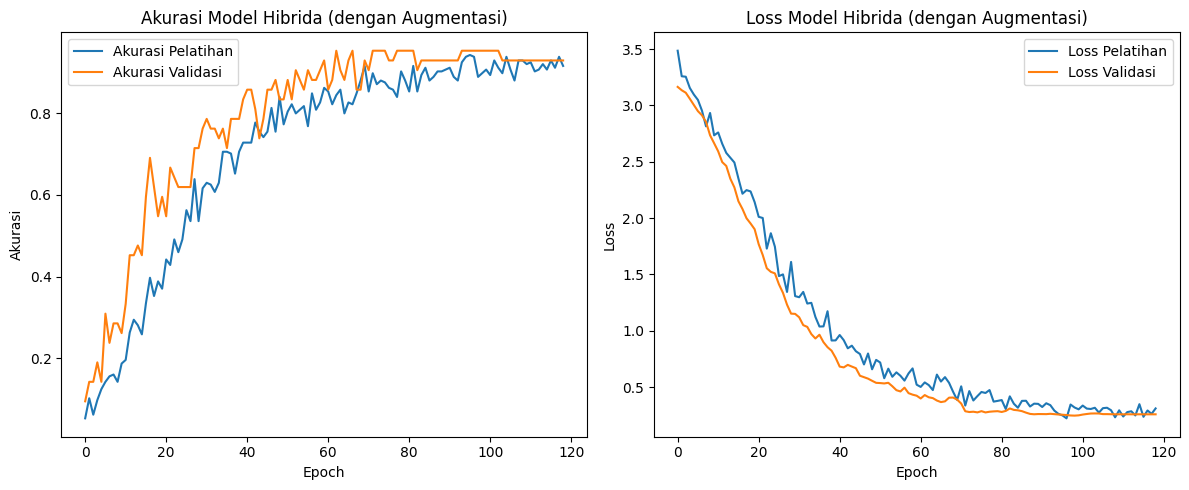

In [ ]:
if hybrid_model is not None and X_images_train is not None and \
   'train_image_datagen' in locals() and train_image_datagen is not None and \
   callable(hybrid_data_generator):

    if X_images_train.shape[0] > 0 :
        train_generator_instance = hybrid_data_generator(
            X_images_train,
            X_landmarks_train,
            y_train,
            BATCH_SIZE,
            train_image_datagen
        )

        steps_per_epoch = len(X_images_train) // BATCH_SIZE
        if len(X_images_train) % BATCH_SIZE != 0:
            steps_per_epoch += 1

        checkpoint_path = os.path.join(MODELS_PATH, 'best_hybrid_model_augmented.keras')
        model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.000001, verbose=1)

        print("Memulai pelatihan model hibrida dengan augmentasi gambar...")
        history_hybrid = hybrid_model.fit(
            train_generator_instance,
            epochs=200,
            steps_per_epoch=steps_per_epoch,
            validation_data=({'image_input': X_images_val, 'landmark_input': X_landmarks_val}, y_val),
            callbacks=[model_checkpoint, early_stopping, reduce_lr],
            verbose=1
        )
        print("Pelatihan model hibrida selesai.")

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history_hybrid.history['accuracy'], label='Akurasi Pelatihan')
        plt.plot(history_hybrid.history['val_accuracy'], label='Akurasi Validasi')
        plt.title('Akurasi Model Hibrida (dengan Augmentasi)')
        plt.xlabel('Epoch')
        plt.ylabel('Akurasi')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history_hybrid.history['loss'], label='Loss Pelatihan')
        plt.plot(history_hybrid.history['val_loss'], label='Loss Validasi')
        plt.title('Loss Model Hibrida (dengan Augmentasi)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Tidak ada data pelatihan (X_images_train kosong) untuk membuat generator. Pelatihan dilewati.")
        history_hybrid = None
else:
    print("Model hibrida, data pelatihan, atau generator augmentasi tidak siap. Pelatihan dilewati.")
    if 'train_image_datagen' not in locals() or train_image_datagen is None:
        print("- ImageDataGenerator untuk pelatihan tidak terdefinisi.")
    if not callable(hybrid_data_generator):
        print("- Fungsi hybrid_data_generator tidak terdefinisi.")
    history_hybrid = None


Mengevaluasi model hibrida pada data pengujian...

Loss pada data pengujian: 0.3635
Akurasi pada data pengujian: 90.70%
2/2 [==============================] - 2s 220ms/step

Laporan Klasifikasi Model Hibrida:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         2
           B       1.00      1.00      1.00         2
           C       1.00      1.00      1.00         3
           D       0.00      0.00      0.00         0
           E       0.50      1.00      0.67         1
           F       1.00      1.00      1.00         2
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       0.67      1.00      0.80         2
           J       1.00      0.50      0.67         4
           K       1.00      0.67      0.80         3
           L       1.00      1.00      1.00         2
           M       1.00      1.00      1.00         2
           N       1.00      1.00

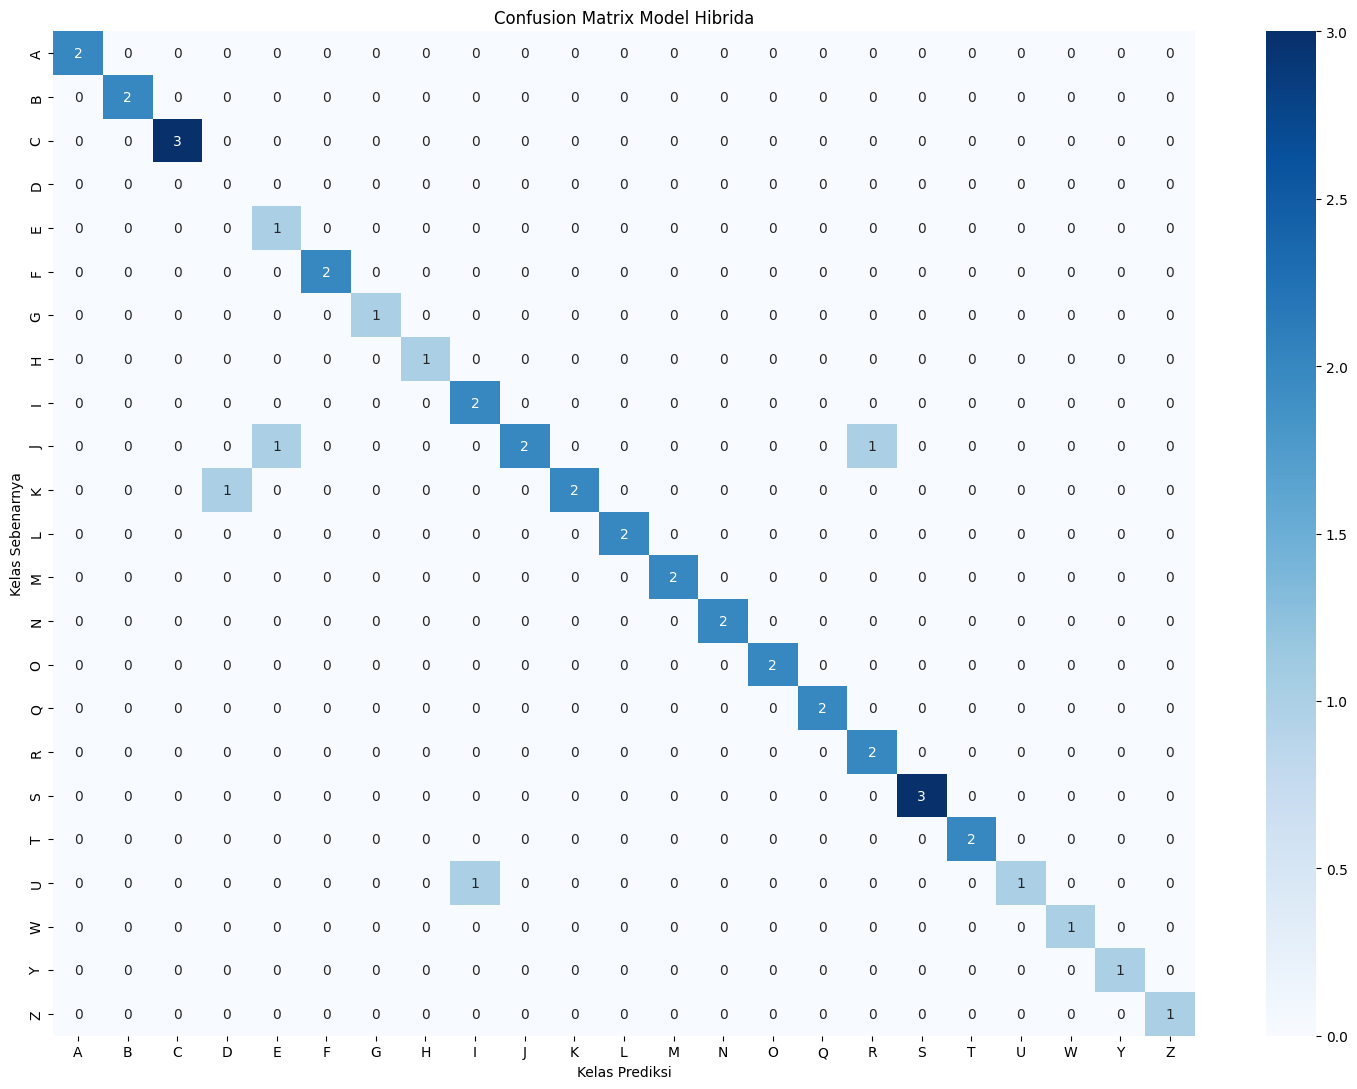

In [ ]:
if hybrid_model is not None and X_images_test is not None and history_hybrid is not None:
    print("\nMengevaluasi model hibrida pada data pengujian...")
    evaluation_model = hybrid_model

    loss, accuracy = evaluation_model.evaluate(
        {'image_input': X_images_test, 'landmark_input': X_landmarks_test},
        y_test,
        verbose=0
    )
    print(f"\nLoss pada data pengujian: {loss:.4f}")
    print(f"Akurasi pada data pengujian: {accuracy*100:.2f}%")

    y_pred_probabilities = evaluation_model.predict(
        {'image_input': X_images_test, 'landmark_input': X_landmarks_test}
    )
    y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\nLaporan Klasifikasi Model Hibrida:")
    if class_names_loaded and len(class_names_loaded) > 0 :
        present_labels = np.unique(np.concatenate((y_true_classes, y_pred_classes)))


        filtered_target_names = [class_names_loaded[i] for i in present_labels if i < len(class_names_loaded)]
        if len(filtered_target_names) == len(present_labels):
            print(classification_report(y_true_classes, y_pred_classes,
                                        labels=present_labels,
                                        target_names=filtered_target_names,
                                        zero_division=0))
        else:
            print("Peringatan: Jumlah nama target yang difilter tidak cocok dengan jumlah label unik yang ada.")
            print(f"  Label unik: {present_labels} (Jumlah: {len(present_labels)})")
            print(f"  Nama target terfilter: {filtered_target_names} (Jumlah: {len(filtered_target_names)})")
            print("  Mencoba membuat laporan hanya dengan label unik (tanpa nama target kustom)...")
            print(classification_report(y_true_classes, y_pred_classes,
                                        labels=present_labels,
                                        zero_division=0))
    else:
        print("Nama kelas tidak tersedia atau kosong untuk laporan klasifikasi.")

    if 'present_labels' in locals() and 'filtered_target_names' in locals() and len(present_labels) == len(filtered_target_names):
        cm = confusion_matrix(y_true_classes, y_pred_classes, labels=present_labels)
        plt.figure(figsize=(max(10, len(filtered_target_names) // 1.5 if filtered_target_names else 10),
                           max(8, len(filtered_target_names) // 2 if filtered_target_names else 8)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=filtered_target_names,
                    yticklabels=filtered_target_names)
    elif 'present_labels' in locals():
        cm = confusion_matrix(y_true_classes, y_pred_classes, labels=present_labels)
        plt.figure(figsize=(max(10, len(present_labels) // 1.5 if present_labels.size > 0 else 10),
                           max(8, len(present_labels) // 2 if present_labels.size > 0 else 8)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=present_labels,
                    yticklabels=present_labels)
    else:
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title('Confusion Matrix Model Hibrida')
    plt.ylabel('Kelas Sebenarnya')
    plt.xlabel('Kelas Prediksi')
    plt.tight_layout()
    plt.show()
else:
    print("Model hibrida atau data pengujian tidak siap, atau pelatihan tidak dilakukan. Evaluasi dilewati.")

In [ ]:
if hybrid_model is not None and history_hybrid is not None:
    final_hybrid_model_path = os.path.join(MODELS_PATH, 'final_hybrid_sign_language_model_augmented.keras')
    hybrid_model.save(final_hybrid_model_path)
    print(f"Model hibrida final (dengan augmentasi) berhasil disimpan di: {final_hybrid_model_path}")

    print("\n--- Konversi ke TensorFlow.js (Perhatian) ---")
    print("Model dengan banyak input seperti ini mungkin memerlukan penanganan khusus saat dikonversi dan digunakan di TensorFlow.js.")
    print("Anda mungkin perlu memproses input secara terpisah di JavaScript dan memberikannya sebagai dictionary ke model.predict().")
    print(f"Contoh perintah konversi (jalankan di terminal setelah mengunduh model):")
    print(f"tensorflowjs_converter --input_format keras \\")
    print(f"                       {final_hybrid_model_path} \\")
    print(f"                       {os.path.join(MODELS_PATH, 'tfjs_hybrid_model_augmented')}")
else:
    print("Model hibrida belum dilatih. Tidak ada yang disimpan.")

Model hibrida final (dengan augmentasi) berhasil disimpan di: /content/drive/MyDrive/Capstone/models_hybrid/final_hybrid_sign_language_model_augmented.keras

--- Konversi ke TensorFlow.js (Perhatian) ---
Model dengan banyak input seperti ini mungkin memerlukan penanganan khusus saat dikonversi dan digunakan di TensorFlow.js.
Anda mungkin perlu memproses input secara terpisah di JavaScript dan memberikannya sebagai dictionary ke model.predict().
Contoh perintah konversi (jalankan di terminal setelah mengunduh model):
tensorflowjs_converter --input_format keras \
                       /content/drive/MyDrive/Capstone/models_hybrid/final_hybrid_sign_language_model_augmented.keras \
                       /content/drive/MyDrive/Capstone/models_hybrid/tfjs_hybrid_model_augmented


In [ ]:
from IPython.display import display, Image
if 'hybrid_model' in locals() and hybrid_model is not None and \
   'class_names_loaded' in locals() and class_names_loaded and len(class_names_loaded) > 0:

    best_model_to_predict_path = os.path.join(MODELS_PATH, 'best_hybrid_model_augmented.keras')
    if os.path.exists(best_model_to_predict_path):
        print(f"Memuat model terbaik dari: {best_model_to_predict_path} untuk prediksi.")
        try:
            prediction_model = tf.keras.models.load_model(best_model_to_predict_path)
        except Exception as e:
            print(f"Error saat memuat model terbaik: {e}. Menggunakan 'hybrid_model' yang ada di memori (jika pelatihan baru saja selesai).")
            prediction_model = hybrid_model
    else:
        print(f"Model terbaik ({best_model_to_predict_path}) tidak ditemukan. Menggunakan 'hybrid_model' yang ada di memori (jika tersedia dan valid).")

        if not isinstance(prediction_model, tf.keras.Model):
             print("Peringatan: 'hybrid_model' yang ada di memori juga tidak valid. Tidak dapat melanjutkan prediksi.")
             prediction_model = None

    if prediction_model:
        mp_hands_predict_module = mp.solutions.hands
        hands_for_single_prediction = mp_hands_predict_module.Hands(
            static_image_mode=True,
            max_num_hands=2,
            min_detection_confidence=0.5
        )

        print("\nSilakan unggah gambar untuk diprediksi...")
        uploaded_files = files.upload()

        if not uploaded_files:
            print("Tidak ada file yang diunggah.")
        else:
            for file_name in uploaded_files.keys():
                print(f'\nMemproses gambar: {file_name}')
                temp_image_path = file_name

                image_bgr_pred = cv2.imread(temp_image_path)
                if image_bgr_pred is None:
                    print(f"  Error: Tidak dapat membaca gambar {temp_image_path}")
                    continue

                resized_image_pred = cv2.resize(image_bgr_pred, (IMAGE_WIDTH, IMAGE_HEIGHT))
                normalized_image_pred = resized_image_pred.astype('float32') / 255.0
                image_input_pred = np.expand_dims(normalized_image_pred, axis=0)

                landmarks_input_pred_raw = extract_landmarks_from_image(image_bgr_pred, hands_for_single_prediction)

                if landmarks_input_pred_raw is not None:
                    landmarks_input_pred = np.expand_dims(landmarks_input_pred_raw, axis=0)
                    prediction_probabilities = prediction_model.predict(
                        {'image_input': image_input_pred, 'landmark_input': landmarks_input_pred},
                        verbose=0
                    )
                    predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]

                    if 0 <= predicted_class_index < len(class_names_loaded):
                        predicted_class_name = class_names_loaded[predicted_class_index]
                        confidence = prediction_probabilities[0][predicted_class_index] * 100
                        print(f"\n  Prediksi Isyarat: {predicted_class_name}")
                        print(f"  Keyakinan: {confidence:.2f}%")
                    else:
                        print(f"  Error: Indeks kelas hasil prediksi ({predicted_class_index}) di luar jangkauan (0-{len(class_names_loaded)-1}).")
                else:
                    print("  Tidak dapat mendeteksi tangan atau mengekstrak landmark pada gambar yang diunggah.")

                try:
                    os.remove(temp_image_path)
                except OSError as e:
                    print(f"  Error saat menghapus file {temp_image_path}: {e}")

        hands_for_single_prediction.close()
        print("\nSesi prediksi gambar tunggal selesai.")
else:
    print("Model hibrida belum dilatih/dimuat, atau nama kelas tidak tersedia/kosong. Tidak dapat melakukan prediksi.")
    if 'hybrid_model' not in locals() or hybrid_model is None:
         print("- Variabel 'hybrid_model' tidak ditemukan atau None.")
    if 'class_names_loaded' not in locals() or not class_names_loaded:
         print("- Variabel 'class_names_loaded' tidak ditemukan atau kosong.")


Memuat model terbaik dari: /content/drive/MyDrive/Capstone/models_hybrid/best_hybrid_model_augmented.keras untuk prediksi.

Silakan unggah gambar untuk diprediksi...


Saving wall white (3).jpg to wall white (3).jpg

Memproses gambar: wall white (3).jpg

  Prediksi Isyarat: B
  Keyakinan: 67.17%

Sesi prediksi gambar tunggal selesai.
